In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.data.util_tools import *

%load_ext autoreload
%autoreload 2

config==========================================
running config.py
project dir /home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu
raw data dir /home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/data/raw
processed data dir /home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/data/processed
reports dir /home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/reports
model dir /home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/models
loaded .env file from /home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/.env
StartDate: 2024-01-01  EndDate: None
NrDataPoints: None
selected sensor_types: ['temperature', 'voc', 'co2', 'humidity', 'light', 'uv', 'pressure']
==========================================config


In [2]:
df = pd.read_parquet('../data/raw/co2_data.parquet')
df.head()
#df.info() # sensor 230 has 0 entries!

,sensor_2,sensor_21,sensor_40,sensor_59,sensor_85,sensor_104,sensor_123,sensor_145,sensor_164,sensor_184,sensor_210,sensor_230,sensor_251,sensor_269
timestamp,,,,,,,,,,,,,,
2024-01-18 16:20:57,465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2024-01-18 16:21:50,464.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2024-01-18 16:22:42,466.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2024-01-18 16:23:34,467.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2024-01-18 16:24:25,467.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


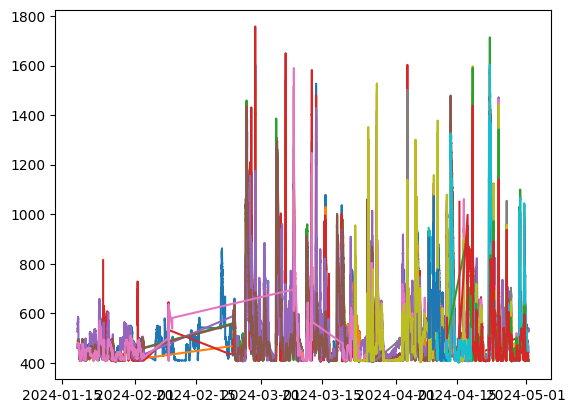

In [3]:
plt.plot(df)
plt.show()

## Find  a series with a small amount of NaN

In [4]:
#plot_all_sensors(df) # Look at the plot.html in the browser!

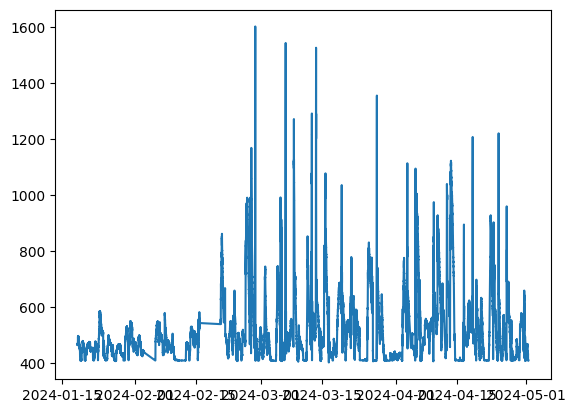

In [3]:
plt.plot(df['sensor_2'])
plt.show()
# There is a lot of NAN's in this sensor lets see if we can interpolate it

# Lets preprocess the data before we continue, resample it and then interpolate it:
Check test_resample.ipynb in the smart_city project

In [3]:
df_sensor_2 = pd.DataFrame(df['sensor_2']) # I decided to look into sensor 2

In [5]:
df_resampled = resample_data(df_sensor_2)
df_resampled.to_parquet('../data/interim/df_resampled.parquet')

Resampling data
Data has been upsampled to :0.1min and downsampled to 2min"


# ADF
     Inputs:
     maxlag : {None, int}
         Maximum lag which is included in test, default value of
         12*(nobs/100)^{1/4} is used when ``None``.
     regression : {"c","ct","ctt","n"}
         Constant and trend order to include in regression.
         
    Outputs:
    adf : float
        The test statistic.
    pvalue : float
        MacKinnon's approximate p-value based on MacKinnon (1994, 2010).

    

There are no correct parameter, the ts has to be observed and then decided which regression should be choosen. Depending if the series has a trend, seasonality or none of both the regression can be set to c = constant, ct = constant trend ,or ctt = **constant trend trend-squared?? when to use ctt?? (ASK PERNSTICH)!**
 About maxlag -> use default cause it looks for the best possible parameter!, For further information look into [Notebook](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)
 


## Test for stationarity:


In [ ]:
stationarity_tests(df_sensor_2)

Stationarity tests


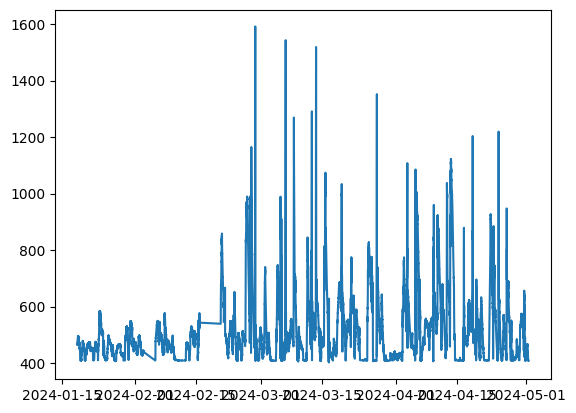

In [6]:
plt.plot(df_resampled)

# KPSS
    (KPSS) test for the null
    hypothesis that x is level or trend stationary
    
    Inputs:    
        regression : str{"c", "ct"}
        The null hypothesis for the KPSS test.
        * "c" : The data is stationary around a constant (default).
        * "ct" : The data is stationary around a trend.
    nlags : {str, int}, optional
        Indicates the number of lags to be used. If "auto" (default), lags
        is calculated using the data-dependent method of Hobijn et al. (1998).
    
    Outputs:
        kpss_stat : float
            The KPSS test statistic.
        p_value : float
            The p-value of the test. The p-value is interpolated from
            Table 1 in Kwiatkowski et al. (1992), and a boundary point
            is returned if the test statistic is outside the table of
            critical values, that is, if the p-value is outside the
            interval (0.01, 0.1).




## Possible outcomes after stationarity tests:

    Case 1: Both tests conclude that the series is not stationary - The series is not stationary
    Case 2: Both tests conclude that the series is stationary - The series is stationary
    Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
    Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In our case for sensor_2 the series is accordin to adfuller and kpss stationary! -> Case 2 see above
Is this correct? It looks not stationary to me from eyeballing the data.


# Lets do a seasonal_decomposition:
Key Questions to answer:  
**What is the proper value for the period parameter?**  
As we use data that is orignally sampled per minute (in case of co_2) we could think that a seasonal compononent is either daily or ?weekly? --> **is defined as datapoints per period, in our case we have 24h and resampled to 2min, means our period would be period = 720**
**Is there a difference when all data (incl. Missing data) is used or if only a portion w/o missing data is used?**   
The function doesn't allow NAN's <3 

seasonal_decomposition:
seasonal_decomposition: done with a  multiplicative model and period 720


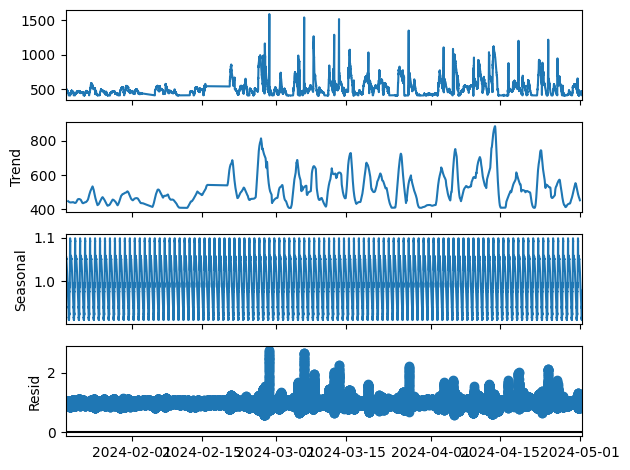

In [9]:
seansonal = seasonal_decomposition(df_resampled)
seansonal

Use Seasonal and Trend decomposition using Loess (STL) 
 Key Questions to answer:  
**What is the proper value for the period parameter?**  
Again most probably 12 -> months,  52-> weeks or 365 -> days  (ts only 5 months so the period vary?)
**Is there a difference when all data (incl. Missing data) is used or if only a portion w/o missing data is used?**   
The Loess decomp works also if there are NAN's in the data, after the first NAN the decomposition stops and don't continue..


loess_decomposition:
loess_decomposition: done with a seasonal: 5  and period 720


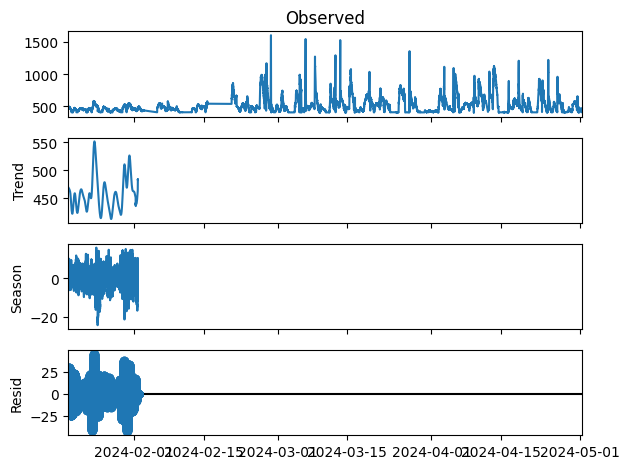

In [10]:
loess = loess_decomposition(df_sensor_2)
loess

loess_decomposition:
loess_decomposition: done with a seasonal: 5  and period 52


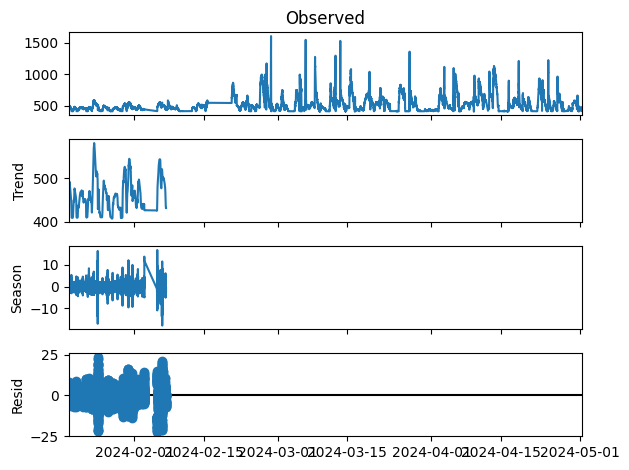

In [11]:
loess2 = loess_decomposition(df_sensor_2)

# Residual Analysis
- Box Plot
- ACF and pacf

Text(0, 0.5, 'Residuals')

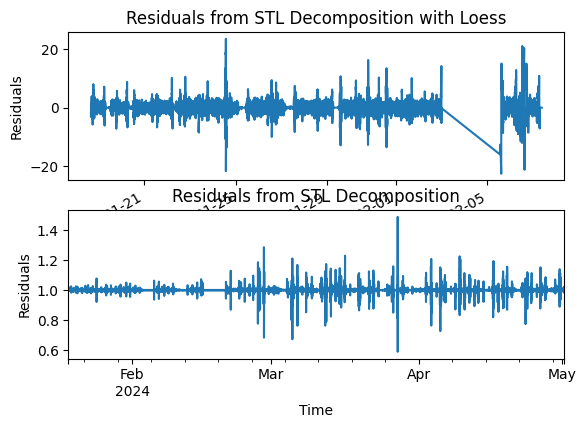

In [12]:
loess_resid = loess2.resid
stl_resid = seansonal.resid

plotting ACF:


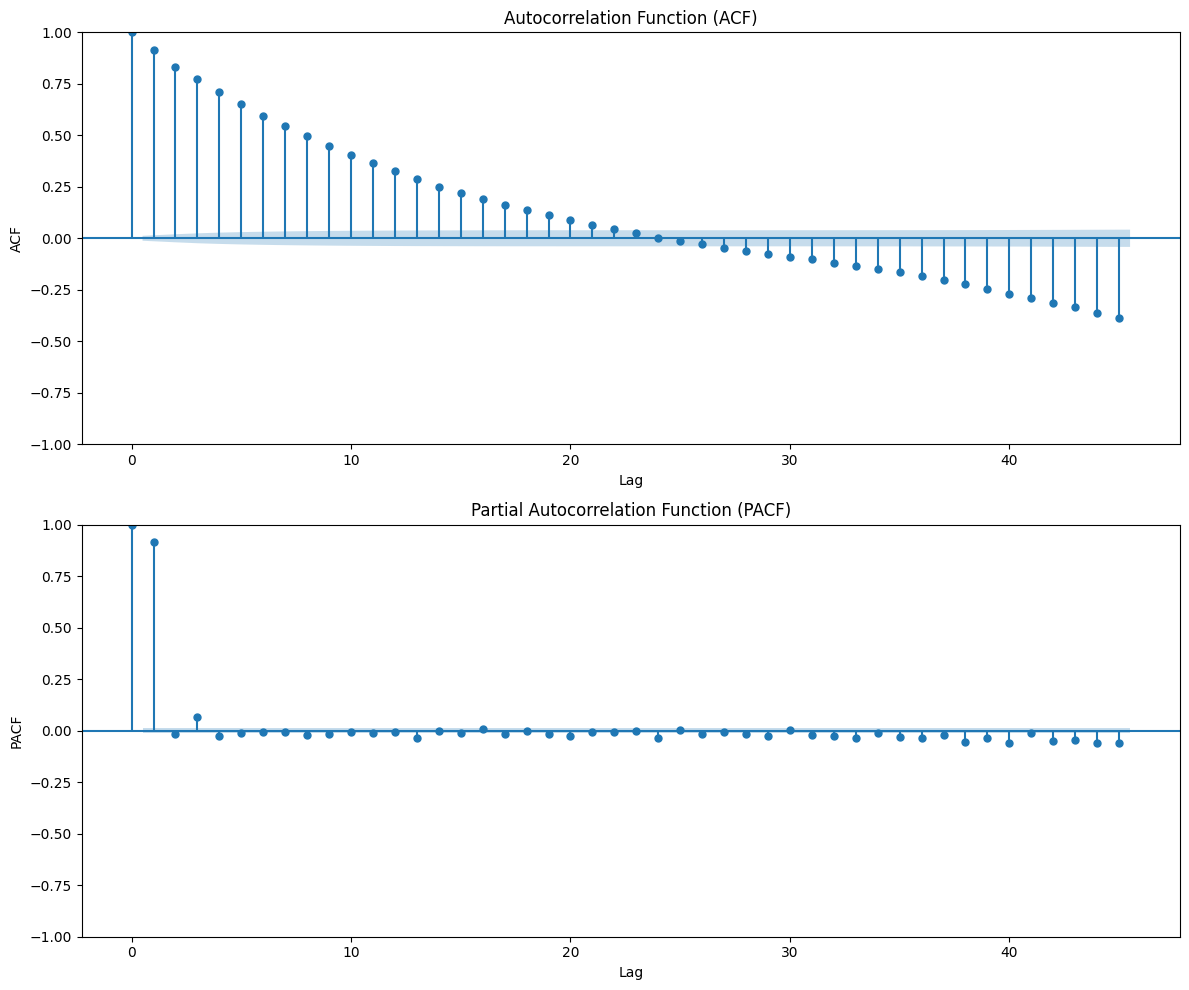

ACF and PACF plots saved as ./data/images/acf_resid_1715636368.png


In [60]:
acf_plotting(loess_resid)

plotting ACF:


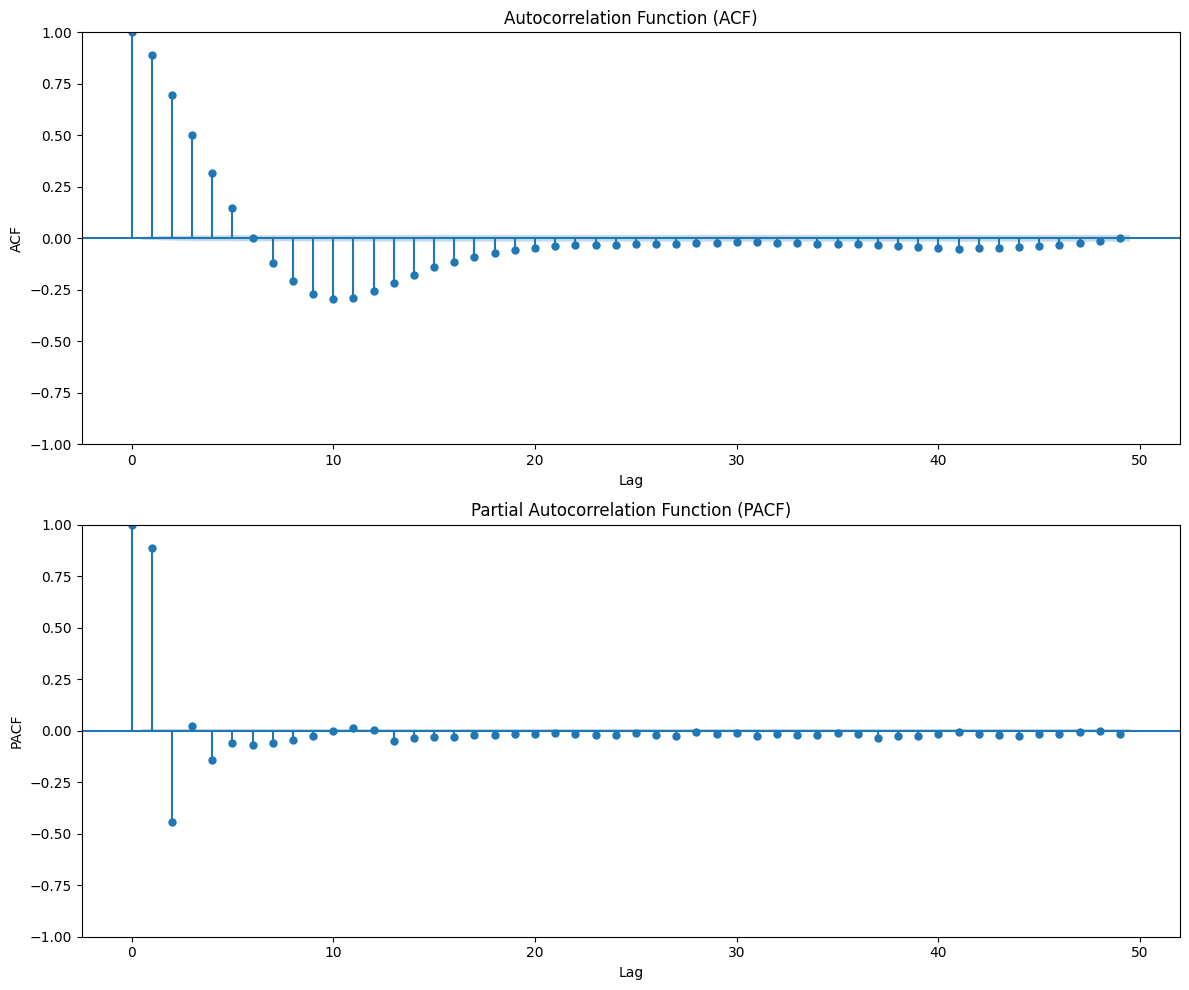

ACF and PACF plots saved as ./data/images/acf_resid_1715636447.png


In [61]:
acf_plotting(stl_resid)